In [180]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

from random import randint

import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix

Loading all images and reserving 20% for validation...

In [174]:
train_dataset = tf.keras.utils.image_dataset_from_directory("./data/seg_train", image_size=(150, 150), seed=69, color_mode="rgb")
test_dataset = tf.keras.utils.image_dataset_from_directory("./data/seg_test", image_size=(150, 150), seed=69, color_mode="rgb")

len(train_dataset)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


439

Let's visualise the class distribution in the training dataset...

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Class distribution in training dataset:
buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


2025-06-01 12:17:38.852487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


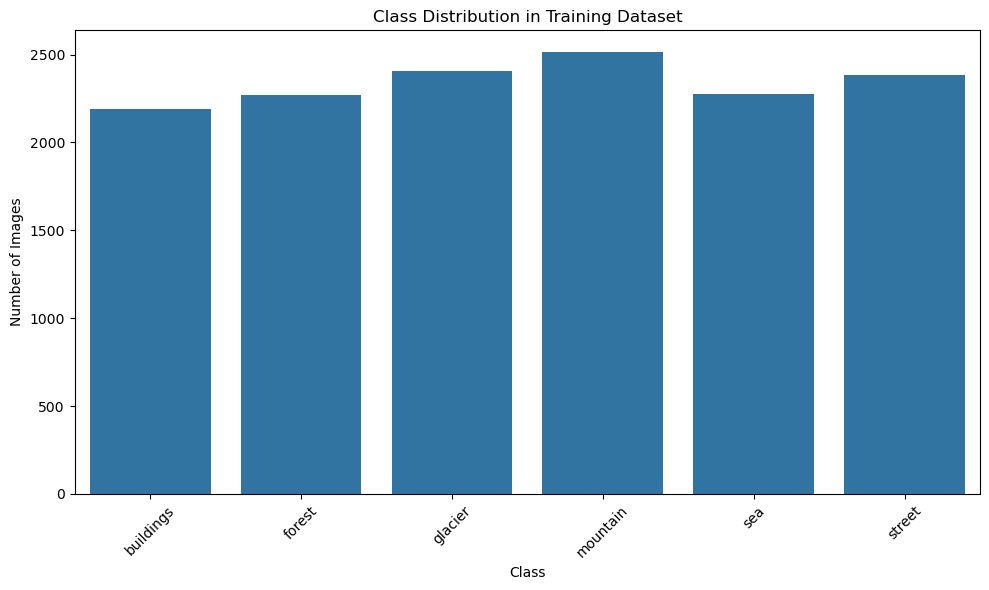

In [175]:
class_names = train_dataset.class_names
print(f"Classes: {class_names}")

class_counts = {name: 0 for name in class_names}

for images, labels in train_dataset:
    label_counts = Counter(labels.numpy())
    
    for label, count in label_counts.items():
        class_counts[class_names[label]] += count

print("\nClass distribution in training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We have a nicely distributed training dataset...

Visualing an image in the dataset...

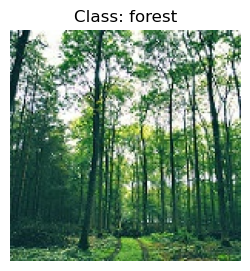

2025-06-01 12:17:41.085545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(3, 3))
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"{class_names[labels[0]]}")
    plt.axis("off")
    plt.show()


---

Before anything else, we need to preprocess the images in the datasets. This may include normalising / rescaling pixel values, converting to greyscale, and maybe tweaking contrast...

In [153]:
# rescale data
train_dataset = train_dataset.map(lambda x, y : (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y : (x / 255.0, y))

for image, labels in train_dataset.take(1):
    print((np.min(image[0]), np.max(image[0])))
    print(image[0].shape)
    
# improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


(0.0, 1.0)
(150, 150, 3)


2025-06-01 00:50:15.643708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's make a model!

In [ ]:
model = tfk.Sequential([tfkl.Conv2D(32, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001) ,input_shape=(150, 150, 3)), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.MaxPool2D(),
                        tfkl.Conv2D(128, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001)), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.MaxPool2D(),
                        tfkl.Conv2D(256, kernel_size=3, strides=1), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.MaxPool2D(),
                        
                        tfkl.Flatten(), tfkl.Dense(128), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.Dropout(0.5),
                        tfkl.Dense(256), tfkl.BatchNormalization(), tfkl.ReLU(),
                        tfkl.Dense(len(class_names))
])

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [155]:
for batch, _ in train_dataset:
    print(batch.shape)
    break

model.compile(optimizer="adam", loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

(32, 150, 150, 3)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_77 (ReLU)                 │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 72, 72, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 72, 72, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_78 (ReLU)                 │ (None, 72, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 34, 34, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_79 (ReLU)                 │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │     9,470,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_80 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_81 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,840,902 (37.54 MB)

 Trainable params: 9,839,302 (37.53 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [156]:
# dynamic LR
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,                
    verbose=1,                 
    min_lr=1e-6
)

n_epochs = 25

history = model.fit(train_dataset, validation_data=test_dataset, epochs=n_epochs, callbacks=[lr_scheduler])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.5944 - loss: 1.0511 - val_accuracy: 0.2683 - val_loss: 2.7497 - learning_rate: 0.0010
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.7672 - loss: 0.6604 - val_accuracy: 0.6470 - val_loss: 0.9589 - learning_rate: 0.0010
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.8026 - loss: 0.5520 - val_accuracy: 0.7807 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 4/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.8405 - loss: 0.4578 - val_accuracy: 0.7933 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 5/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.8493 - loss: 0.4124 - val_accuracy: 0.7893 - val_loss: 0.6108 - learning_rate: 0.0010
Epoch 6/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.8748 - loss: 0.3539 - val_accuracy: 0.7953 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 7/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.89

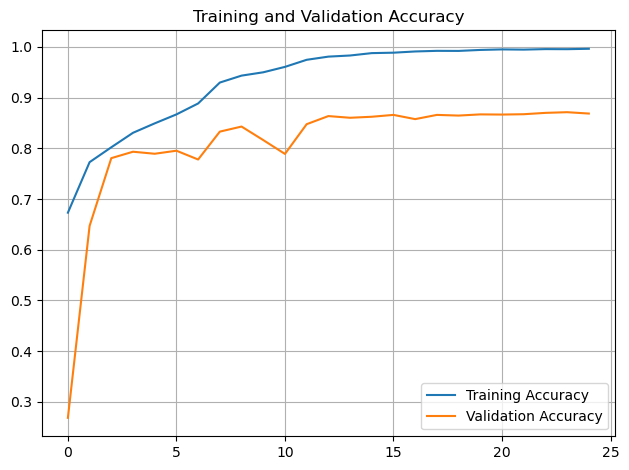

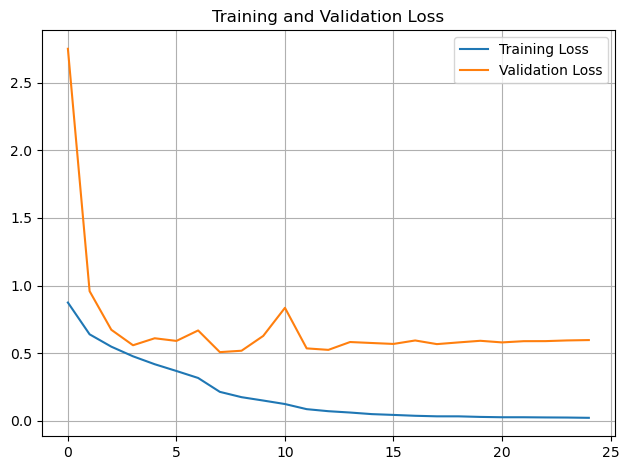

In [157]:
epochs_range = range(n_epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

2025-06-01 01:13:38.145388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


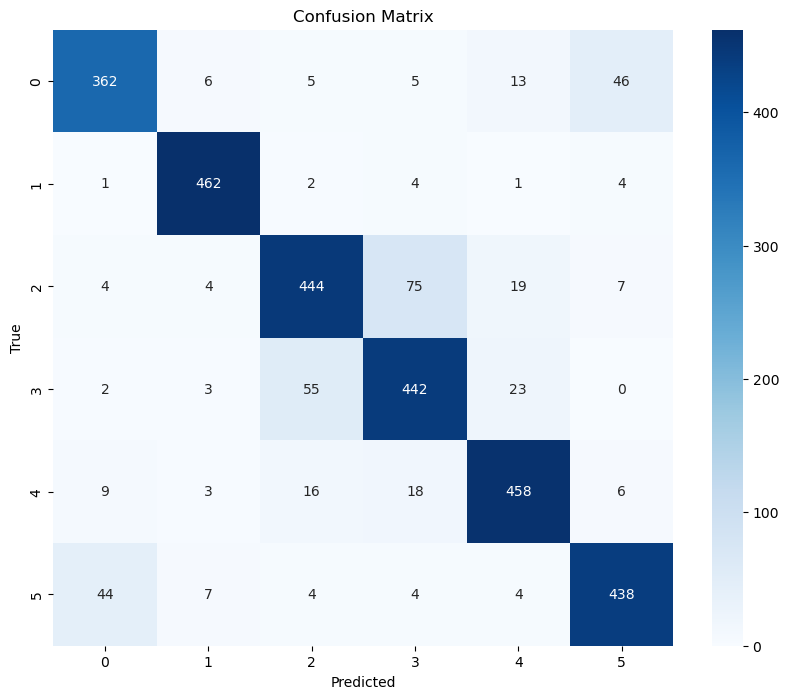

In [158]:
y_true = []
y_pred_classes = []

# Loop through the dataset
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())  # assuming one-hot encoded labels
    y_pred_classes.extend(np.argmax(preds, axis=1))
    

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [210]:
model.save('image_classifier.keras')

---

Let's try to predict some images from the pred dataset...

In [211]:
pred_dataset = tf.keras.utils.image_dataset_from_directory("./data/seg_pred", image_size=(150, 150), seed=69, color_mode="rgb")
pred_dataset = pred_dataset.map(lambda x, y: (x / 255.0, y))

len(pred_dataset)

print(class_names)

Found 7301 files belonging to 1 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Selecting Batch # 85
(32, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


2025-06-01 12:39:18.816561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


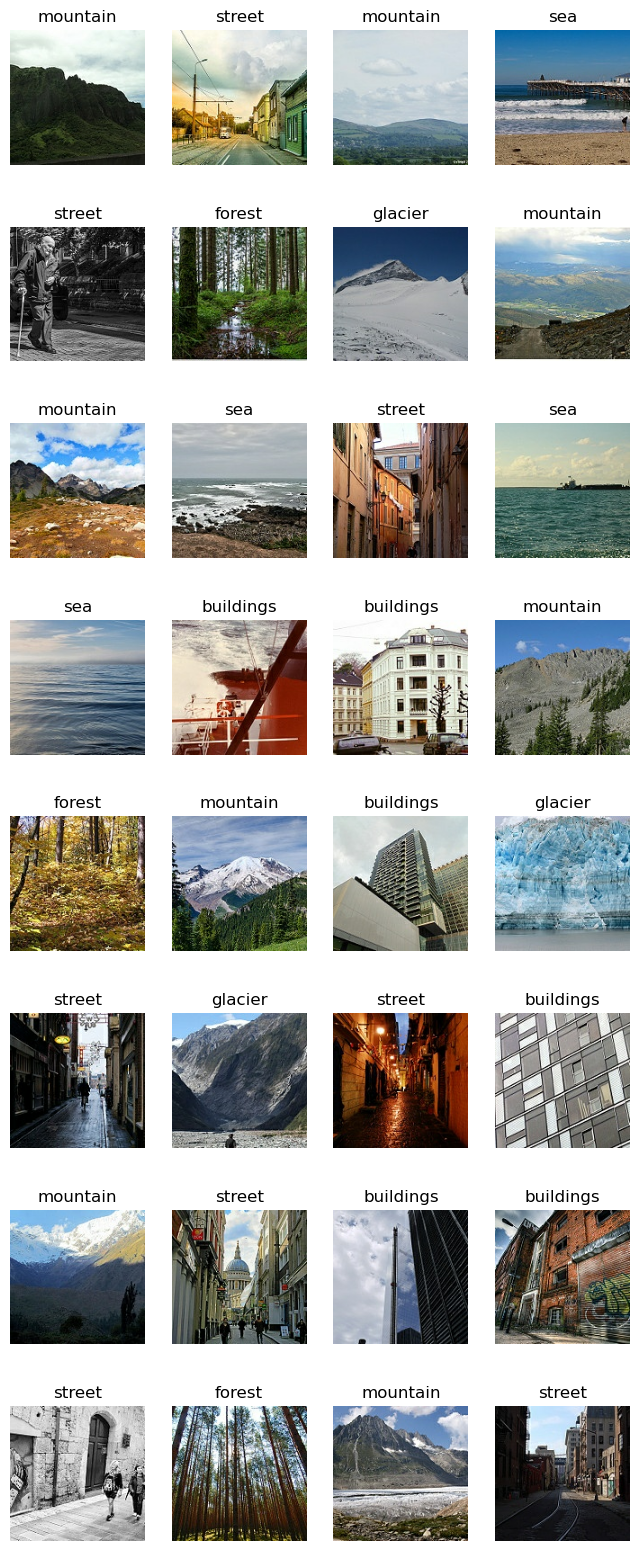

In [212]:
fig, axes = plt.subplots(8, 4, figsize=(8, 20))
axes = axes.flatten()

random_idx = randint(1, 229)
print(f"Selecting Batch # {random_idx}")

for imgs, labels in pred_dataset.skip(random_idx - 1).take(1):
    print(imgs.shape)
    
    # get predictions for the images
    preds = model.predict(imgs)
    pred_classes = tf.argmax(preds, axis=1)

    for i in range(len(imgs)):
        axes[i].set_axis_off()
        axes[i].imshow(imgs[i].numpy())
        axes[i].set_title(f"{class_names[pred_classes[i]]}")

Pretty happy with the predictions the model gives me. It definitely gets caught when the images combine two or more classifications as once, such as streets and buildings, or mountains with glaciers and/or forests, but that's to be expected.

---